## 자료분석특론2 HW7
### 212STG10 박영은

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

In [10]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


## < Problem 1 > 

In [14]:
y = pd.DataFrame(y)
y.columns = ['target']

y_index = y[y['target'].isin(['3', '5', '6', '7'])].index
y_index

Int64Index([    0,     7,    10,    11,    12,    13,    15,    18,    27,
               29,
            ...
            69979, 69981, 69982, 69986, 69988, 69989, 69990, 69996, 69998,
            69999],
           dtype='int64', length=27623)

In [82]:
new_X = X[y_index,]
new_y = y.iloc[y_index,:]
new_y = new_y.reset_index().drop(columns='index', axis=1)

## < Problem 2, 3, 4 >

### KMeans

Text(0.55, 0.55, 'Elbow')

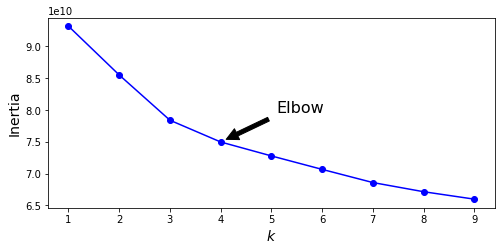

In [51]:
# inertia 그래프
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(new_X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

3에서 살짝 elbow가 생긴다. 하지만 명확하게 드러나지 않으므로 실루엣 계수를 참고하여 클러스터 계수를 정하고자 한다.

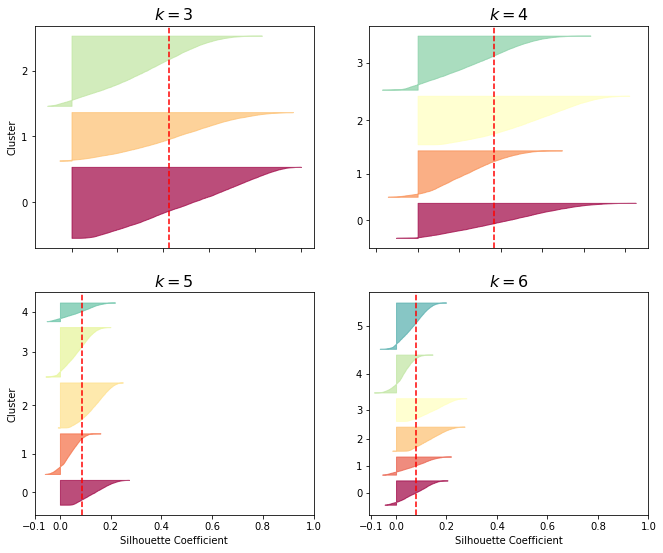

In [50]:
# 실루엣 게수 

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(new_X) for k in range(3, 7)]
silhouette_scores = [silhouette_score(new_X, model.labels_)
                     for model in kmeans_per_k]

plt.figure(figsize=(11, 9))
for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 3].labels_
    silhouette_coefficients = silhouette_samples(new_X, y_pred)
    padding = len(new_X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
        facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
    plt.axvline(x=silhouette_scores[k - 3], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

위 그래프는 실루엣 계수를 시각화한 것이다. 각 cluster의 width도 비슷하고, 모두 평균을 넘는 지점이 있는 cluster 4를 최적으로 선택하여 하이퍼파라미터 튜닝을 진행하고자 한다.

In [131]:
# 기본 모델
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(new_X)
y_pred = pd.DataFrame(y_pred)
compare = pd.concat([new_y, y_pred], axis=1)  # 5 -> 1, 3 ->3, 6 ->0, 7->2

for i in range(len(y_pred)):
    if compare.iloc[i,1] == 1:
        compare.loc[i,'fixed_y_pred'] = 5
    elif compare.iloc[i,1] == 3:
        compare.loc[i,'fixed_y_pred'] = 3
    elif compare.iloc[i,1] == 0:
        compare.loc[i,'fixed_y_pred'] = 6
    else:
        compare.loc[i,'fixed_y_pred'] = 7
        
compare['target'] = compare['target'].astype('int64')
# 정확도
accuracy_score(compare['target'], compare['fixed_y_pred'])

0.7507511856061977

In [132]:
# inertia
kmeans_rnd_10_inits.inertia_ 

74970816497.64552

#### 하이퍼파라미터 튜닝

In [130]:
# 하이퍼파라미터 튜닝(max_iter 변경) 
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, max_iter = 500)
y_pred = kmeans.fit_predict(new_X)
y_pred = pd.DataFrame(y_pred)
compare = pd.concat([new_y, y_pred], axis=1)  # 5 -> 1, 3 ->3, 6 ->0, 7->2

for i in range(len(y_pred)):
    if compare.iloc[i,1] == 1:
        compare.loc[i,'fixed_y_pred'] = 5
    elif compare.iloc[i,1] == 3:
        compare.loc[i,'fixed_y_pred'] = 3
    elif compare.iloc[i,1] == 0:
        compare.loc[i,'fixed_y_pred'] = 6
    else:
        compare.loc[i,'fixed_y_pred'] = 7
        
compare['target'] = compare['target'].astype('int64')
# 정확도
accuracy_score(compare['target'], compare['fixed_y_pred'])

0.7507511856061977

In [116]:
# 하이퍼파라미터 튜닝(다중 초기화) 
# -> 랜덤 초기화를 다르게 하여 여러 번 실행하고 가장 작은 이너셔를 만드는 군집을 선택
k = 4
kmeans_rnd_10_inits = KMeans(n_clusters=k, init="random", n_init=20,
 algorithm="full", random_state=42)
y_pred = kmeans_rnd_10_inits.fit_predict(new_X)
y_pred = pd.DataFrame(y_pred)
compare = pd.concat([new_y, y_pred], axis=1)  # 5 -> 3, 3 ->1, 6 ->0, 7->2
compare.head(50)

,target,0
0,5,3
1,3,1
2,3,1
3,5,3
4,3,1
5,6,0
6,7,2
7,6,3
8,3,1
9,7,3


In [117]:
for i in range(len(y_pred)):
    if compare.iloc[i,1] == 1:
        compare.loc[i,'fixed_y_pred'] = 3
    elif compare.iloc[i,1] == 3:
        compare.loc[i,'fixed_y_pred'] = 5
    elif compare.iloc[i,1] == 0:
        compare.loc[i,'fixed_y_pred'] = 6
    else:
        compare.loc[i,'fixed_y_pred'] = 7
        
compare['target'] = compare['target'].astype('int64')
# 정확도
accuracy_score(compare['target'], compare['fixed_y_pred'])

0.7507511856061977

In [118]:
# inertia
kmeans_rnd_10_inits.inertia_ 

74970816497.64552

In [207]:
# 하이퍼파라미터 튜닝(K-평균++)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
y_pred = kmeans.fit_predict(new_X)
y_pred = pd.DataFrame(y_pred)
compare = pd.concat([new_y, y_pred], axis=1)  # 5 -> 1, 3 ->3, 6 ->0, 7->2
compare.head(50)

,target,0
0,5,1
1,3,3
2,3,3
3,5,1
4,3,3
5,6,0
6,7,2
7,6,1
8,3,3
9,7,1


In [208]:
for i in range(len(y_pred)):
    if compare.iloc[i,1] == 1:
        compare.loc[i,'fixed_y_pred'] = 5
    elif compare.iloc[i,1] == 3:
        compare.loc[i,'fixed_y_pred'] = 3
    elif compare.iloc[i,1] == 0:
        compare.loc[i,'fixed_y_pred'] = 6
    else:
        compare.loc[i,'fixed_y_pred'] = 7
        
compare['target'] = compare['target'].astype('int64')
# 정확도
accuracy_score(compare['target'], compare['fixed_y_pred'])

0.7507511856061977

In [128]:
# inertia
kmeans.inertia_ 

74970816497.64552

In [166]:
print(pd.crosstab(compare['target'], compare['fixed_y_pred']))

fixed_y_pred   3.0   5.0   6.0   7.0
target                              
3             5410  1478    64   189
5             2624  3388   102   199
6               39  1744  5070    23
7               44   361    18  6870


init과 n_init을 바꾸어가며 튜닝을 시도했지만, 정확도와 inertia 값의 변화가 없다. 따라서, 0.75의 정확도를 가지는 기본 모델을 kmeans를 사용했을 때 최적의 모델로 선정한다.

In [253]:
# 최적 모델에 대해 이상치 개수 확인 및 시각화
compare['same']= (compare['target']) == (compare['fixed_y_pred'])

# 클러스터링이 잘 되지 않은 이상점 개수
print('이상점 개수: ', compare[compare['same']==False].same.count())

이상점 개수:  6885


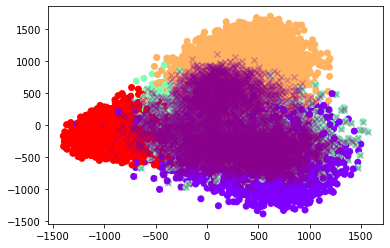

In [245]:
pca = PCA(n_components=2)  # pca를 진행해 클러스터가 얼마나 잘됐는지 검토
X_pca = pca.fit_transform(new_X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=compare['target'], cmap=plt.cm.rainbow)
for i in range(len(compare)):
    if (compare.loc[i,'same'])==False:
        plt.scatter(X_pca[i, 0], X_pca[i, 1], marker='x', color='darkmagenta', alpha=0.3)

plot을 그리기 위해 pca로 데이터를 2차원으로 축소했으며, 보라색 x 마커가 이상점을 나타낸 것이다.

### GMM

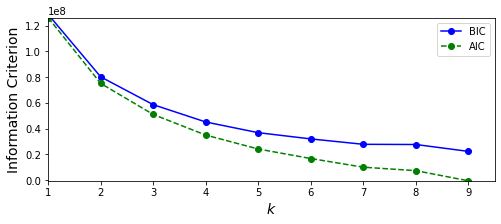

In [153]:
gmm_per_k = [GaussianMixture(n_components=k, random_state=42).fit(new_X) for k in range(1, 10)]

aics = [model.aic(new_X) for model in gmm_per_k]
bics = [model.bic(new_X) for model in gmm_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 10), bics, "bo-", label="BIC")
plt.plot(range(1, 10), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])

plt.legend()
plt.show()

위 모델은 모든 하이퍼파라미터 값을 default로 두고 k(그룹의 개수)만 바꾸어가며 aic, bic를 계산한 것을 보여주는 그래프이다. 해당 그래프로는 elbow가 명확히 보이지 않는다. 따라서 k와 covariance type 조합을 직접 찾고자 한다. 그 전 데이터의 차원이 매우 커서 시간이 오래 소요된다는 점을 고려하여 차원 축소를 진행한다.

In [159]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(new_X)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

153

153개의 차원으로 축소하면 데이터의 약 0.95 정도의 정보를 가지게 된다. 원래의 784개의 열을 모두 가져가면 clustering 시간이 매우 오래 소요되므로 153차원으로 축소하여 사용하고자 한다.

In [161]:
pca = PCA(n_components = 153)
X_reduced = pca.fit_transform(new_X)

In [162]:
min_bic = np.infty
for k in range(2, 7):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
            covariance_type=covariance_type,
            random_state=42).fit(X_reduced).bic(X_reduced)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

C:\Users\User\anaconda3\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [163]:
best_k

6

In [164]:
best_covariance_type

'full'

In [165]:
min_bic

45385850.42431646

In [168]:
gmm = GaussianMixture(n_components=6, n_init=10,
            covariance_type='full',
            random_state=42)
y_pred = gmm.fit_predict(X_reduced)

In [169]:
y_pred = pd.DataFrame(y_pred)
compare = pd.concat([new_y, y_pred], axis=1)  # 3-> 1 or 5, 5 -> 0, 6 -> 3 or 2, 7 ->4 

# 예측 비교
result = compare.groupby(['target'])[0].value_counts()
print(result)

target  0
3       1    3742
        5    2668
        0     716
        3       7
        4       6
        2       2
5       0    2788
        5    1802
        1    1657
        3      39
        2      27
6       3    3209
        2    3109
        1     408
        5     129
        0      21
7       4    5173
        5    1738
        0     377
        1       5
Name: 0, dtype: int64


In [170]:
for i in range(len(y_pred)):
    if (compare.iloc[i,1] == 1)|(compare.iloc[i,1] == 5):
        compare.loc[i,'fixed_y_pred'] = 3
    elif compare.iloc[i,1] == 3:
        compare.loc[i,'fixed_y_pred'] = 6
    elif compare.iloc[i,1] == 0:
        compare.loc[i,'fixed_y_pred'] = 5
    else:
        compare.loc[i,'fixed_y_pred'] = 7
        
compare['target'] = compare['target'].astype('int64')
# 정확도
accuracy_score(compare['target'], compare['fixed_y_pred'])

0.6364261666002968

약 64%의 정확도를 가지고 잘 분류되었다. 집단은 6개로 분류되었지만, 원래 레이블과 비교해본 결과, true y 레이블이 3인 경우는 많은 observation들이 두 집단으로 분류되었으며, 7일 때도 그렇다. 따라서 predicted된 6개의 집단을 4개로 묶어서 true 값과 비교해볼 수 있었다.

6개의 집단으로 분류했을 때 4개로 잘 묶였으므로 처음부터 4개로 분류를 다시 해보았다.

In [254]:
gmm_10 = GaussianMixture(n_components=4, n_init=10,
            covariance_type='full',
            random_state=42)
y_pred = gmm_10.fit_predict(X_reduced)

C:\Users\User\anaconda3\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [255]:
y_pred = pd.DataFrame(y_pred)
compare = pd.concat([new_y, y_pred], axis=1)  # 3-> 1 or 5, 5 -> 0, 6 -> 3 or 2, 7 ->4 

# 예측 비교
result = compare.groupby(['target'])[0].value_counts()
print(result)

target  0
3       2    4329
        3    2784
        0      28
5       3    3598
        2    2677
        1      35
        0       3
6       1    5788
        2     731
        3     357
7       0    5680
        2    1427
        3     186
Name: 0, dtype: int64


In [256]:
for i in range(len(y_pred)):
    if (compare.iloc[i,1] == 1):
        compare.loc[i,'fixed_y_pred'] = 6
    elif compare.iloc[i,1] == 3:
        compare.loc[i,'fixed_y_pred'] = 5
    elif compare.iloc[i,1] == 0:
        compare.loc[i,'fixed_y_pred'] = 7
    else:
        compare.loc[i,'fixed_y_pred'] = 3
        
compare['target'] = compare['target'].astype('int64')
# 정확도
accuracy_score(compare['target'], compare['fixed_y_pred'])

0.7021322810701227

정확도가 70%로 증가했다.

In [174]:
gmm_4_tied = GaussianMixture(n_components=4, n_init=10,
            covariance_type='tied',
            random_state=42)
y_pred = gmm_4_tied.fit_predict(X_reduced)

In [175]:
y_pred = pd.DataFrame(y_pred)
compare = pd.concat([new_y, y_pred], axis=1)  # 3-> 1 or 5, 5 -> 0, 6 -> 3 or 2, 7 ->4 

# 예측 비교
result = compare.groupby(['target'])[0].value_counts()
print(result)

target  0
3       1    5110
        2    1229
        0     521
        3     281
5       1    3462
        2    2244
        0     496
        3     111
6       3    4397
        2    2257
        1     222
7       0    6248
        2     937
        1     108
Name: 0, dtype: int64


In [176]:
for i in range(len(y_pred)):
    if (compare.iloc[i,1] == 1):
        compare.loc[i,'fixed_y_pred'] = 3
    elif compare.iloc[i,1] == 2:
        compare.loc[i,'fixed_y_pred'] = 5
    elif compare.iloc[i,1] == 0:
        compare.loc[i,'fixed_y_pred'] = 7
    else:
        compare.loc[i,'fixed_y_pred'] = 6
        
compare['target'] = compare['target'].astype('int64')
# 정확도
accuracy_score(compare['target'], compare['fixed_y_pred'])

0.6515946855880969

65%로 감소했다. 따라서, GaussianMixture(n_components=4, n_init=10, covariance_type='full') 조합을 최적으로 선택한다.

이상점 개수:  8228


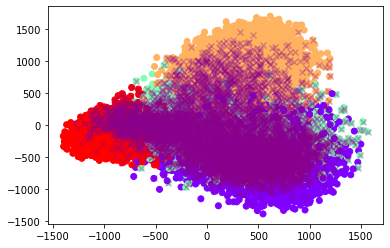

In [257]:
# 최적 모델에 대해 이상치 개수 확인 및 시각화
compare['same']= (compare['target']) == (compare['fixed_y_pred'])

# 클러스터링이 잘 되지 않은 이상점 개수
print('이상점 개수: ', compare[compare['same']==False].same.count())

pca = PCA(n_components=2)  # pca를 진행해 클러스터가 얼마나 잘됐는지 검토
X_pca = pca.fit_transform(new_X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=compare['target'], cmap=plt.cm.rainbow)
for i in range(len(compare)):
    if (compare.loc[i,'same'])==False:
        plt.scatter(X_pca[i, 0], X_pca[i, 1], marker='x', color='darkmagenta', alpha=0.3)

plot을 그리기 위해 pca로 데이터를 2차원으로 축소했으며, 보라색 x 마커가 이상점을 나타낸 것이다.

### BayesianGaussianMixture

In [182]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42, covariance_type='full')
bgm.fit(X_reduced)
y_pred = bgm.predict(X_reduced)
np.round(bgm.weights_, 2)

array([0.12, 0.06, 0.09, 0.11, 0.1 , 0.13, 0.14, 0.1 , 0.07, 0.08])

In [259]:
bgm_4 = BayesianGaussianMixture(n_components=4, n_init=10, random_state=42, covariance_type='full')
bgm_4.fit(X_reduced)
y_pred = bgm_4.predict(X_reduced)
np.round(bgm_4.weights_, 2)

C:\Users\User\anaconda3\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


array([0.26, 0.32, 0.21, 0.21])

In [260]:
y_pred = pd.DataFrame(y_pred)
compare = pd.concat([new_y, y_pred], axis=1)  # 3-> 1 or 5, 5 -> 0, 6 -> 3 or 2, 7 ->4 

# 예측 비교
result = compare.groupby(['target'])[0].value_counts()
print(result)

target  0
3       1    4110
        0    3022
        3       9
5       0    3718
        1    2559
        2      35
        3       1
6       2    5894
        1     655
        0     327
7       3    5679
        1    1444
        0     170
Name: 0, dtype: int64


In [261]:
for i in range(len(y_pred)):
    if (compare.iloc[i,1] == 1):
        compare.loc[i,'fixed_y_pred'] = 3
    elif compare.iloc[i,1] == 0:
        compare.loc[i,'fixed_y_pred'] = 5
    elif compare.iloc[i,1] == 3:
        compare.loc[i,'fixed_y_pred'] = 7
    else:
        compare.loc[i,'fixed_y_pred'] = 6
        
compare['target'] = compare['target'].astype('int64')
# 정확도
accuracy_score(compare['target'], compare['fixed_y_pred'])

0.7023494913658908

정확도가 70%가 나왔다.

In [ ]:
bgm_4 = BayesianGaussianMixture(n_components=4, n_init=10, random_state=42, covariance_type='tied')
bgm_4.fit(X_reduced)
y_pred_bgm_4 = bgm_4.predict(X_reduced)
np.round(bgm_4.weights_, 2)

In [188]:
y_pred_bgm_4 = pd.DataFrame(y_pred_bgm_4)
compare = pd.concat([new_y, y_pred_bgm_4], axis=1)  # 3-> 1 or 5, 5 -> 0, 6 -> 3 or 2, 7 ->4 

# 예측 비교
result = compare.groupby(['target'])[0].value_counts()
print(result)

target  0
3       1    5120
        3    1234
        0     518
        2     269
5       1    3465
        3    2238
        0     490
        2     120
6       2    4536
        3    2118
        1     222
7       0    6151
        3    1037
        1     105
Name: 0, dtype: int64


In [189]:
for i in range(len(y_pred)):
    if (compare.iloc[i,1] == 1):
        compare.loc[i,'fixed_y_pred'] = 3
    elif compare.iloc[i,1] == 3:
        compare.loc[i,'fixed_y_pred'] = 5
    elif compare.iloc[i,1] == 0:
        compare.loc[i,'fixed_y_pred'] = 7
    else:
        compare.loc[i,'fixed_y_pred'] = 6
        
compare['target'] = compare['target'].astype('int64')
# 정확도
accuracy_score(compare['target'], compare['fixed_y_pred'])

0.6532599645223184

65%로 감소했다. 따라서, BayesianGaussianMixture(n_components=4, n_init=10, random_state=42, covariance_type='full')를 최적으로 선택한다.

이상점 개수:  8222


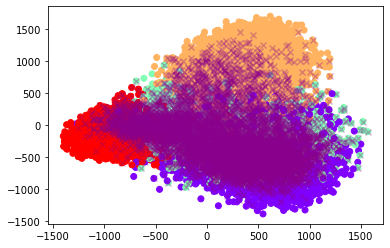

In [262]:
# 최적 모델에 대해 이상치 개수 확인 및 시각화
compare['same']= (compare['target']) == (compare['fixed_y_pred'])

# 클러스터링이 잘 되지 않은 이상점 개수
print('이상점 개수: ', compare[compare['same']==False].same.count())

pca = PCA(n_components=2)  # pca를 진행해 클러스터가 얼마나 잘됐는지 검토
X_pca = pca.fit_transform(new_X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=compare['target'], cmap=plt.cm.rainbow)
for i in range(len(compare)):
    if (compare.loc[i,'same'])==False:
        plt.scatter(X_pca[i, 0], X_pca[i, 1], marker='x', color='darkmagenta', alpha=0.3)

plot을 그리기 위해 pca로 데이터를 2차원으로 축소했으며, 보라색 x 마커가 이상점을 나타낸 것이다.